![Tulane](https://github.com/tulane-cmps6730/main/blob/main/img/banner.png?raw=true)

<center>

<font size="+3">Sequence Models II</font>

[Aron Culotta](https://cs.tulane.edu/~aculotta/)  
[Tulane University](https://cs.tulane.edu/)

<a href="http://colab.research.google.com/github/tulane-cmps6730/main/blob/main/notebooks/06_Sequence_Models_II.ipynb">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Google_Colaboratory_SVG_Logo.svg/320px-Google_Colaboratory_SVG_Logo.svg.png"  width=10%/></a>
<a href="https://github.com/tulane-cmps6730/main/tree/main">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/GitHub_Invertocat_Logo.svg/240px-GitHub_Invertocat_Logo.svg.png" width=6%/></a>

In this module, we'll learn about neural network models for text sequences, including recurrent neural networks (RNNs) and long short-term memory networks (LSTMs)

</center>

<hr size=10 color=#285C4D>

## Long-range Dependencies in Language

Hidden Markov models can make predictions over a sequence.

Some limitations:

- long-range dependencies: "The **students** studied for **their** test."
  - must "remember" that "students" is plural to know to use "their" and not "his/hers"
- forward only: only considers previous words, but future words may help for, e.g., part-of-speech tagging


<br><br>

Why is it hard to include long-range dependencies?


$$p(q_i \mid q_{i-1}) = \frac{C(q_{i-1}, q_i)}{C(q_{i-1})}$$

$$p(q_i \mid q_{i-1}, q_{i-2}) = \frac{C(q_{i-2}, q_{i-1}, q_i)}{C(q_{i-1}, q_{i-2})}$$

$$p(q_i \mid q_{i-1}, q_{i-2}, q_{i-3}) = \frac{C(q_{i-3}, q_{i-2}, q_{i-1}, q_i)}{C(q_{i-1}, q_{i-2}, q_{i-3})}$$

![trellis](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/trellis.png?raw=1)

<hr size=10 color=#285C4D>

## Recurrent Neural Networks


### Overview


(adapted from [here](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/))

- Sequence model for neural networks
- Similar to Hidden Markov models

![rnn_roll](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/rnn_roll.png?raw=1)

- $x_t$: input at time  $t$.
  - E.g., a word.
- $h_t$: hidden state at time  $t$.
  - The “memory” of the network.
  - $h_t$ is a function of the previous hidden state ($h_{t-1}$) and the current input ($x_t$).
    - Similar to HMMs, where we have $p(y_t \mid y_{t-1}, x_t)$
    - $h_t=f(W_{xh}x_t + W_{hh} h_{t-1})$
      - $f$ :  activation function (e.g., sigmoid, tanh, etc)
      - $W_{xh}$: analogous to "emission" probabilities in HMMs
      - $W_{hh}$: analogous to "transition" probabilities in HMMs
- $y_t$: output at time $t$
  - E.g., to predict the next word in a sentence it would be a vector of probabilities across our vocabulary. $y_t = \mathrm{softmax}(W_{hy}h_t).$

<br>

This "unrolled" network is a multi-layer neural net

- E.g., if the sentence has 5 words, we have 5 layers
- Unlike a typical neural net, the parameters are <u>shared</u> across layers
  - That is, $W_{xh}$, $W_{hh}$, and $W_{hy}$ are the same everywhere.
  

<br><br>

Dimensions of weight matrices depends on

- input dimension $d_x~~~~~~~~~~~~~~~~$ $x_t \in \mathbb{R}^{d_x}$
- hidden state dimension $d_h~~~~$ $h_t \in \mathbb{R}^{d_h}$
- output dimension $d_y~~~~~~~~~~~~~~$ $y_t \in \mathbb{R}^{d_y}$

thus

- $W_{xh} \in \mathbb{R}^{d_h \times d_x}$
- $W_{hh} \in \mathbb{R}^{d_h \times d_h}$
- $W_{hy} \in \mathbb{R}^{d_y \times d_h}$

<br><br>

Unlike HMMs, we will estimate parameters $W_{xh}$, $W_{hh}$, and $W_{hy}$ with gradient descent (rather than counting)

<br><br>

### Types of Recurrent NNs



(following [this nice tutorial](http://karpathy.github.io/2015/05/21/rnn-effectiveness/))

  
![rnn_styles](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/rnn_styles.png?raw=1)
- red=input
- green=network state
- blue=output
<br><br>
- one-to-one: no RNN; e.g., image classification
- one-to-many: image -> caption
- many-to-one: sentiment classification
- many-to-many, unsynchronized: translation
- many-to-many, synchronized: POS tagging
  


### A simple implementation of Recurrent Neural Nets



A basic RNN has a `step` function, which takes an `x` vector as input and returns a `y` vector as output.

Letting
- $W_{hh}$ be the transition weights (from hidden state $t$ to hidden state $t+1$)
- $W_{xh}$ be the emission weights (from hidden state $h$ to observation $x$)
- $W_{hy}$ be the output weights (from hidden state $h$ to prediction $y$)
- $\mathrm{tanh}(z) \in [-1, 1]$ be the activation function
  - like logistic, but in $[-1,1]$ instead of $[0,1]$

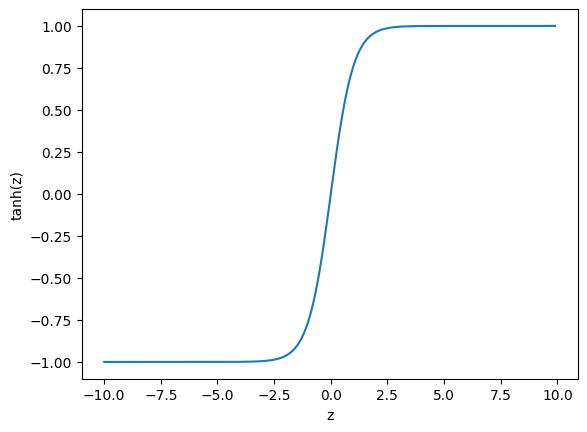

In [5]:
# tanh activation function
import numpy as np
import matplotlib.pyplot as plt


zs = np.arange(-100,100) / 10
plt.figure()
plt.plot(zs, [np.tanh(z) for z in zs])
plt.ylabel('tanh(z)')
plt.xlabel('z')
plt.show()

To update the hidden state $h$:

$$h_t = \mathrm{tanh}(W_{hh}h_{t-1} + W_{xh}x_t)$$

To compute the output vector $y$:

$$y_t = W_{hy} h_t$$

```python
class RNN:
  def step(self, x):
    # update the hidden state
    self.h = np.tanh(np.dot(self.W_hh, self.h) + np.dot(self.W_xh, x))
    # compute the output vector
    y = np.dot(self.W_hy, self.h)
    return y

```

In [6]:
### RNN
class RNN:
    def __init__(self, n_input, n_hidden, n_output):
        # initialize to small weights
        np.random.seed(42)
        self.W_xh = np.random.randn(n_hidden, n_input) * .01
        self.W_hh = np.random.randn(n_hidden, n_hidden) * .01
        self.W_hy = np.random.randn(n_output, n_hidden) * .01
        self.h = np.random.randn(n_hidden, 1) * .01

    def step(self, x):
        # update the hidden state
        self.h = np.tanh(np.dot(self.W_hh, self.h) + np.dot(self.W_xh, x))
        # compute the output vector
        print(self.h.shape)
        y = np.dot(self.W_hy, self.h)
        return y

    def __str__(self):
        return 'W_xh:\n%s\nW_hh:\n%s\nW_hy:%s\nh:\n%s\n' % (
            str(self.W_xh),
            str(self.W_hh),
            str(self.W_hy),
            str(self.h)
                                                           )

### RNN Example: Character Language Model



Predict the next character in the sequence.

![char](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/char.png?raw=1)

In [7]:
n_chars = 28  # +2 for space and period.
n_hidden = 3
rnn = RNN(n_chars, n_hidden, n_chars)
print(rnn)
# random weights

W_xh:
[[ 0.00496714 -0.00138264  0.00647689  0.0152303  -0.00234153 -0.00234137
   0.01579213  0.00767435 -0.00469474  0.0054256  -0.00463418 -0.0046573
   0.00241962 -0.0191328  -0.01724918 -0.00562288 -0.01012831  0.00314247
  -0.00908024 -0.01412304  0.01465649 -0.00225776  0.00067528 -0.01424748
  -0.00544383  0.00110923 -0.01150994  0.00375698]
 [-0.00600639 -0.00291694 -0.00601707  0.01852278 -0.00013497 -0.01057711
   0.00822545 -0.01220844  0.00208864 -0.0195967  -0.01328186  0.00196861
   0.00738467  0.00171368 -0.00115648 -0.00301104 -0.01478522 -0.00719844
  -0.00460639  0.01057122  0.00343618 -0.0176304   0.00324084 -0.00385082
  -0.00676922  0.00611676  0.01031     0.0093128 ]
 [-0.00839218 -0.00309212  0.00331263  0.00975545 -0.00479174 -0.00185659
  -0.01106335 -0.01196207  0.00812526  0.0135624  -0.0007201   0.01003533
   0.00361636 -0.0064512   0.00361396  0.01538037 -0.00035826  0.01564644
  -0.02619745  0.00821903  0.00087047 -0.00299007  0.00091761 -0.01987569
  -0.

#### One-hot encoding


We represent each character as a binary vector, with a `1` in the cell corresponding to that letter.

![letter](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/letter.png?raw=1)

In [8]:
import string

chars = list(string.ascii_lowercase) + [' ', '.']
char2int_d = dict()
int2char_d = dict()
for i, c in enumerate(chars):
    char2int_d[c] = i
    int2char_d[i] = c

sorted(char2int_d.items(), key=lambda x: x[1])

[('a', 0),
 ('b', 1),
 ('c', 2),
 ('d', 3),
 ('e', 4),
 ('f', 5),
 ('g', 6),
 ('h', 7),
 ('i', 8),
 ('j', 9),
 ('k', 10),
 ('l', 11),
 ('m', 12),
 ('n', 13),
 ('o', 14),
 ('p', 15),
 ('q', 16),
 ('r', 17),
 ('s', 18),
 ('t', 19),
 ('u', 20),
 ('v', 21),
 ('w', 22),
 ('x', 23),
 ('y', 24),
 ('z', 25),
 (' ', 26),
 ('.', 27)]

In [9]:
# to create letter "h"
import torch
def char2vec(char, char2int):
    x = torch.zeros((1, len(char2int)))
    x[0][char2int[char]] = 1
    return x

def chars2vec(chars, char2int):
    return torch.cat([char2vec(c, char2int) for c in chars])
print(char2vec('h', char2int_d))
print()
print(chars2vec('hello', char2int_d))

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])



$$h_t = \mathrm{tanh}(W_{hh}h_{t-1} + W_{xh}x_t)$$

$$y_t = W_{hy} h_t$$


Output vector are weights for the next letter.

Higher weights == more likely letter.

To convert to probabilities, use softmax:

$$
p_t(i) = \frac{e^{y_t(i)}}{\sum_j e^{y_t(j)}}
$$

### Comparison with HMMs



Recall the HMM transition probabilities:
$$p(q_t \mid q_{t-1}) = \frac{C(q_{t-1}, q_t)}{C(q_{t-1})}$$

In RNNs, we instead have a $h$ x $h$ matrix $W_{hh}$ representing transitions:

![trans](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/trans.png?raw=1)

So, whereas in HMMs the states are discrete variables, in RNNs the states are vectors of real numbers, representing the assignment to hidden units.
<br>
This provides additional modeling flexibility:
- E.g., in named-entity tagging, not all adjectives have the same meaning
  - "tall" modifies a Person, "expansive" modifies a Location
- Different adjectives can have different hidden units

### Error function




For the character language model, the training set consists of raw text.

We know the true character that should exist at position $t$.

We can compute the log probability of that true character according to the model, and minimize the negative log of that value.

$$
p_t(i) = \frac{e^{y_t(i)}}{\sum_j e^{y_t(j)}}
$$

$$
E(y_t(i)) = -\log p_t(i)
$$

where $i$ is the true label at time $t$.

We take the average error over all characters as the total error for the current model:

$$
E = \frac{1}{N} \sum_t -\log p_t(i)
$$


**Gradient**

(See [here](http://cs231n.github.io/neural-networks-case-study/#grad) for derivation)

$$
\frac{\partial E(y_t(i))}{\partial y_t(k)} = p_t(k) - \mathbf{1}(y_i = k)
$$
where $\mathbf{1}(y_i = k)$ is $1$ if $y_i=k$.

E.g., if probabilities are [0.2, 0.3, 0.5], and that the correct class was 2 (the middle one).  
The gradient on the scores would be df = [0.2, -0.7, 0.5].

<br><br>

Let's implement this in pytorch.

### Full RNN Example

In [10]:
import torch
import torch.nn as nn
import pandas as pd

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, chars, verbose=True):
        super(RNN, self).__init__()
        self.verbose = verbose
        self.n_hidden = hidden_size
        # W_xh
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        # W_hh
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)
        # W_hy
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        self.chars = chars

    def forward(self, x, h_prev):
        # tanh(𝑊_hh h_t-1 + W_xh x_t)
        h_new = self.tanh(self.hidden_to_hidden(h_prev) + self.input_to_hidden(x))
        # y_h = softmax(W_hy h)
        output = self.hidden_to_output(h_new)

        if self.verbose:
            display(pd.DataFrame([{
                'input': output2label(x, self.chars),
                'h_new': pp(h_new.detach()),
                'output': pp(output),
                'top output': output2label(output, self.chars)}]).transpose())
        return output, h_new

    def forward_unrolled(self, x_list):
        """
        Given a character list, unroll the network and gather
        predictions for each time step.
        """
        hidden = torch.zeros(1, self.n_hidden)
        outputs = []
        hiddens = []
        for x in x_list[:-1]: # no prediction for final step
            output, hidden = self.forward(x, hidden)
            outputs.append(output)
            hiddens.append(hidden)
        return torch.cat(outputs), hiddens

def pp(arr):
  # pretty print weight array
  return arr.detach().cpu().numpy()[0].round(decimals=2)

def output2label(output, chars):
    """
    return the letter for the most probable prediction
    """
    top_n, top_i = output.topk(1)
    return chars[top_i.item()] # , math.exp(top_n)


In [11]:
torch.random.manual_seed(42)
rnn = RNN(n_chars, n_hidden, n_chars, chars)
x = char2vec('h', char2int_d)
hidden = torch.zeros(1, n_hidden)
output, hidden = rnn.forward(x, hidden)

,0
input,h
h_new,"[0.64, -0.12, -0.16]"
output,"[-0.54, 0.3, 0.16, -0.15, 0.03, -0.39, -0.18, ..."
top output,t


In [12]:
chars = ['a', 'b', 'c']
char2int = {'a': 0, 'b': 1, 'c': 2}
int2char = {0: 'a', 1: 'b', 2: 'c'}
data = [
    chars2vec('abcabcabc', char2int),
    chars2vec('bcabcabca', char2int),
    chars2vec('cabcabcab', char2int)
]  * 100

len(data)

300

In [13]:
data[0]

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [14]:
from tqdm import tqdm

def train_model(model, data, epochs=20, learning_rate=0.1, batch_size=10):
    """
    Iterate through the data in batches and train the model.
    NB: this can be made more efficient by writing the
    forward_unrolled method to operate over batches of instances
    rather than single instances. This allows more parellalization,
    but can be more difficult to read.
    """
    torch.random.manual_seed(42)  # for reproducibility
    np.random.seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)
    model.verbose = False
    loss_val = []
    # main training loop
    for epoch in range(epochs):
        print('epoch=%d' % epoch)
        np.random.shuffle(data)
        epoch_loss = 0
        # for each batch of instances
        with tqdm(total=len(data), desc=f'Epoch {epoch+1}/{epochs}', unit='sample') as pbar:
          for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            optimizer.zero_grad() # reset all the gradient information
            batch_loss = 0
            for datum in batch:
                result = model.forward_unrolled(datum)
                loss = criterion(result[0],
                                datum[1:].argmax(dim=1).long())
                batch_loss += loss
            # change parameters after each batch
            batch_loss /= batch_size
            batch_loss.backward()      # computes all the gradients
            optimizer.step()     # update parameters
            loss_val.append(batch_loss.item())
            epoch_loss += batch_loss
            pbar.update(len(batch))
            pbar.set_postfix({'Batch': (i // batch_size) + 1, 'Loss': batch_loss.item()})

        avg_epoch_loss = epoch_loss / (len(data) / batch_size)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_epoch_loss:.4f}')


    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('batches')
    plt.show()
    return model

epoch=0


Epoch 1/2: 100%|██████████| 300/300 [00:00<00:00, 343.37sample/s, Batch=30, Loss=0.000113]


Epoch [1/2], Average Loss: 0.1565
epoch=1


Epoch 2/2: 100%|██████████| 300/300 [00:01<00:00, 299.91sample/s, Batch=30, Loss=4.43e-5]


Epoch [2/2], Average Loss: 0.0001


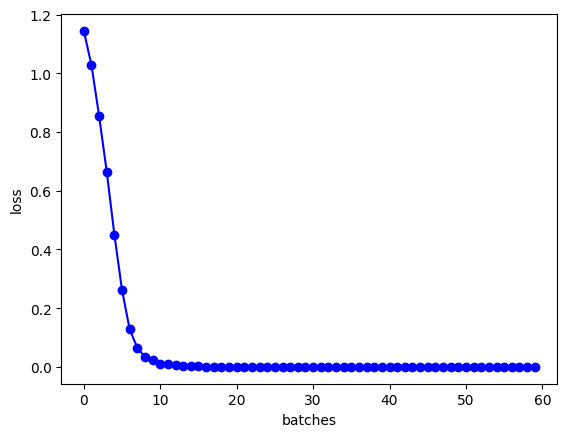

RNN(
  (input_to_hidden): Linear(in_features=3, out_features=3, bias=True)
  (hidden_to_hidden): Linear(in_features=3, out_features=3, bias=True)
  (hidden_to_output): Linear(in_features=3, out_features=3, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [15]:
rnn = RNN(len(chars), 3, len(chars), chars)
train_model(rnn, data, epochs=2, learning_rate=.2, batch_size=10)

In [16]:
rnn.verbose=True
outputs, hidden = rnn.forward_unrolled(chars2vec('ab', char2int))

,0
input,a
h_new,"[0.97, -1.0, 0.99]"
output,"[-3.31, 6.96, -3.75]"
top output,b


### Learn to write like Shakespeare



input:
```
THE SONNETS

by William Shakespeare



                     1
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as the riper should by time decease,
  His tender heir might bear his memory:
  But thou contracted to thine own bright eyes,
  Feed'st thy light's flame with self-substantial fuel,
  Making a famine where abundance lies,
  Thy self thy foe, to thy sweet self too cruel:
  Thou that art now the world's fresh ornament,
  And only herald to the gaudy spring,
  Within thine own bud buriest thy content,
```

In [17]:
import requests
# a simple plain text file
shakes = requests.get('https://raw.githubusercontent.com/tulane-cmps6730/main/refs/heads/main/lec/sequence/shakespeare_small.txt').text
chars = list(set(shakes.lower()))  # restrict to lower
data_size, vocab_size = len(shakes), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
print(sorted(char_to_ix.keys()))

hidden_size = 50 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1



data has 209531 characters, 54 unique.
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\ufeff']


In [18]:
def make_sequences(shakes, sequence_len, char_to_ix):
    sequences = []
    i = 0
    for j in np.arange(len(shakes)+sequence_len)[::sequence_len][1:]:
        row = shakes[i:j]
        i = j
        sequences.append(chars2vec(''.join(row).lower(), char_to_ix))
    return sequences
sequences = make_sequences(shakes, 30, char_to_ix)
sequences[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [19]:
len(char_to_ix)

54

epoch=0


Epoch 1/2: 100%|██████████| 6985/6985 [01:11<00:00, 97.59sample/s, Batch=350, Loss=0.589] 


Epoch [1/2], Average Loss: 2.7057
epoch=1


Epoch 2/2: 100%|██████████| 6985/6985 [01:10<00:00, 98.99sample/s, Batch=350, Loss=0.551] 


Epoch [2/2], Average Loss: 2.2829


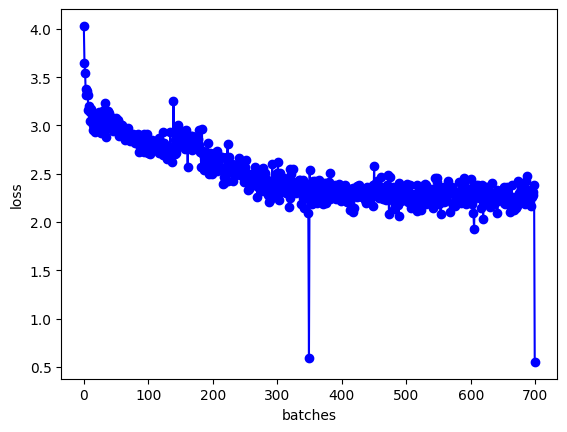

RNN(
  (input_to_hidden): Linear(in_features=54, out_features=80, bias=True)
  (hidden_to_hidden): Linear(in_features=80, out_features=80, bias=True)
  (hidden_to_output): Linear(in_features=80, out_features=54, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [20]:
# to make this work, you'll need many more epochs and possibly a larger hidden layer.
rnn2 = RNN(len(char_to_ix), 80, len(char_to_ix), chars)
train_model(rnn2, sequences, epochs=2, learning_rate=.05, batch_size=20)

In [21]:
# not very good after 2 epochs! (outputting " ")
rnn2.verbose=True
outputs, hidden = rnn2.forward_unrolled(chars2vec('the', char_to_ix))

,0
input,t
h_new,"[0.46, -0.8, -0.25, 0.91, 0.92, 1.0, -0.95, 0...."
output,"[1.71, -1.89, -3.97, -3.67, -9.95, 3.05, -9.15..."
top output,h


,0
input,h
h_new,"[-1.0, -0.99, 1.0, 1.0, 0.98, 1.0, -1.0, 1.0, ..."
output,"[0.26, -2.72, -10.89, -4.74, -16.02, 2.99, -9...."
top output,e


<hr size=10 color=#285C4D>

## RNN Variants

### Multi-layer RNN

More layers and more nodes would improve results:

<u>multi-layer RNN</u>: just stack multiple RNNs together:
```
y1 = rnn1.step(x)
y = rnn2.step(y1)
```

![figs/rnn_stacked.png](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/rnn_stacked.png?raw=1)

Backpropagation can in turn be performed on both networks together.
<br>

3-layer RNN, 512 hidden nodes each, trained for a few hours:

![shake](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/shake.png?raw=1)

### Bidirectional RNN



How can we incorporate future tokens to help the prediction at time $t$?

![figs/birnn.png](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/birnn.png?raw=1)

### Backpropagation through time



- For a single sequence, we can compute back-propagation as in a standard neural net.
- However, because each input sequence has a different length, we have neural nets with different numbers of layers.
- To deal with this, we can collect all sequences of length $t$ and do training on them, then proceed to sequences of length $t+1$:


Repeat:

for $t=1 \ldots T\:\:\:$ ($T$=max length of any sequence):
  - Unfold your neural network in time for $t$ time steps to create a standard feed-forward net.
  - Perform forward and backward propagation as in a normal network.
  - Average all the gradients at each layer, so that the weight update to the matrices is the same in each time step.



<hr size=10 color=#285C4D>

## Long-range dependencies, revisited

### What types of dependencies are we after?


(Adapted from [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [here](https://arxiv.org/abs/1506.00019))

One of the expected advantages of Recurrent Neural Networks is the ability to capture long-range dependencies.

<br>

For example, consider the language modeling problem. Given a sentence like:

> “I grew up in <u>France</u> ... I speak fluent <u>French</u>.”

A trigram language model would have

$$p(\mathrm{French} \mid \mathrm{speak \: fluent}) \approx p(\mathrm{Spanish} \mid \mathrm{speak \: fluent})$$

But, given the presence of the word "France" earlier in the document, we should instead have that

$$p(\mathrm{French} \mid \mathrm{speak \: fluent}) >> p(\mathrm{Spanish} \mid \mathrm{speak \: fluent})$$

<br><br>
It is unscalable to capture such dependencies in a traditional language model or HMM.

Recall that the Viterbi algorithm takes time $O(S^2T)$, where $T$ is the length of the sequence and $S$ is the number of states.

A second-order Markov model conditions on the prior 2 states:

$p(q_i \mid q_{i-2} q_{i-1})$

- must consider 4 combinations of previous states (assuming binary state variables)


A third-order Markov model conditions on the prior 3 states:

$p(q_i \mid q_{i-3} q_{i-2} q_{i-1})$

- must consider 8 combinations of previous states (assuming binary state variables)

- $\rightarrow$ Viterbi complexity is exponential in the order of the model.
- Not to mention the data sparsity issue of fitting higher order probabilities $p(q_i \mid q_{i-3} q_{i-2} q_{i-1})$




### How do Recurrent Neural Networks encode long-range dependencies?



![char](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/char.png?raw=1)

$$
h_t = \mathrm{tanh}(W_{hh}h_{t-1} + W_{xh}x_t)\\
y_t = W_{hy} h_t
$$
- input $x_t$
- hidden $h_t$
- output $y_t$

<br><br>

- Like a first-order HMM, Recurrent NNs only depend on the current input and the prior hidden state.
- However, the hidden state at time $t$ can contain information from an arbitrarily long context window
- How?
  - Given a hidden layer of $n$ binary nodes, how many distinct states can it encode?
    - $2^n$
  - Of course, our hidden nodes are in $\mathbf{R}$, we can represent even more states.
  
Thus, while the <u>expressive power</u> of the network grows exponentially with the number of hidden nodes, the complexity of <u>inference and training</u> grows at most quadratically.

<br>

$$
h_t=f(W_{xh}x_t + W_{hh} h_{t-1})
$$

$$
\begin{bmatrix}
h_{(t-1),1} \ldots h_{(t-1),k}
\end{bmatrix}
\begin{bmatrix}
W_{hh}[11] \ldots W_{hh}[1k]\\
\ldots\\
W_{hh}[k1] \ldots W_{hh}[kk]\\
\end{bmatrix}
$$

$$
O(k^2)
$$

![long](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/long.png?raw=1)


E.g., in the "French" example, if $x_1=\mathrm{France}$, and $x_{t+1} = \mathrm{French}$, our hope is that the hidden layer will retain information about "France" from $h_1$ up to $h_{t+1}$, influencing the prediction at time $t+1$.
<br>


### Vanishing / Exploding gradients



While the above explanation holds in theory, in practice there is an important limitation.

![vanish](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/vanish.png?raw=1)

- Recall that the weights are duplicated (shared) across time steps
  - e.g., $W_{hh}[i,j]$ is the transition weight from hidden node $i$ to hidden node $j$
- If the weight along a recurrent edge is less than 1, then the contribution of input at time $t$ on the hidden layer at time $t+m$ will decrease with $m$.
  - E.g., for three steps: $W_{hh}[i,j] * W_{hh}[i,j] * W_{hh}[i,j]$
- Conversely, if the weight is greater than 1, the contribution will increase over time.

<br>

**This contribution increase/decrease varies <u>exponentially</u> with m (the time gap)!**
  - E.g., for three steps, it's $W_{hh}[i,j]^3$
  
  
<br>
One simple hack for exploding gradients:

> Clip weights to $w_{min} \le W_{hh} \le w_{max}$

e.g., $w_{min}=-5$, $w_{max}=5$

Similar to taking a smaller gradient step.

<br><br>
    
But, doing so hampers the ability of the network to learn long-range dependencies.
  - The size of the clip parameters affects the memory size of the network.
  
  
  
<br><br>

Vanishing gradients can be more problematic...



**Understanding vanishing gradients**

To understand this phenomenon better, let's start with a simpler version of RNNs that ignores the input

$$
h_t = \mathrm{tanh}(W_{hh}h_{t-1})\\
~~~~y_t = W_{hy} h_t
$$

We'll consider sequences of increasing length and see what happens to $h_T$ for the final timestep $T$



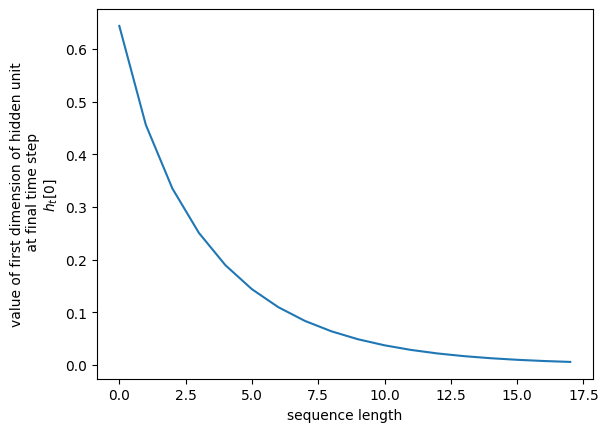

In [22]:
import torch
import torch.nn as nn

class RNNHidden(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, verbose=True):
        super(RNNHidden, self).__init__()
        self.verbose = verbose
        self.n_hidden = hidden_size
        # W_hh
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size, bias=False) # ignore bias for now
        # W_hy
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, h_prev):
        # tanh(𝑊_hh h_t-1 + W_xh x_t)
        # ignoring input
        # h_new = self.tanh(self.hidden_to_hidden(h_prev) + self.input_to_hidden(x))
        h_new = self.tanh(self.hidden_to_hidden(h_prev))
        # y_h = softmax(W_hy h)
        output = self.softmax(self.hidden_to_output(h_new))
        if self.verbose: print('h_new\n', h_new, '\noutput\n',output, '\ntop output\n', output2label(output, chars))
        return output, h_new

    def forward_unrolled(self, x_list, hidden):
        """
        Given a character list, unroll the network and gather
        predictions for each time step.
        Allows the initial hidden state to be passed in.
        """
        # hidden = torch.zeros(1, self.n_hidden)
        outputs = []
        hiddens = []
        for x in x_list[:-1]: # no prediction for final step
            output, hidden = self.forward(x, hidden)
            outputs.append(output)
            hiddens.append(hidden)
        return torch.cat(outputs), hiddens

def output2label(output, chars):
    """
    return the letter for the most probable prediction
    """
    top_n, top_i = output.topk(1)
    return chars[top_i.item()] # , math.exp(top_n)

def char2vec(char, char2int):
    x = torch.zeros((1, len(char2int)))
    x[0][char2int[char]] = 1
    return x

def chars2vec(chars, char2int):
    return torch.cat([char2vec(c, char2int) for c in chars])

torch.random.manual_seed(42)
chars = ['a', 'b', 'c']
char2int = {'a': 0, 'b': 1, 'c': 2}
int2char = {0: 'a', 1: 'b', 2: 'c'}
# let's use a single hidden unit
n_hidden = 1
rnn = RNNHidden(len(chars), n_hidden, len(chars), verbose=False)

optimizer = torch.optim.Adam(rnn.parameters(), lr=.1)
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

# create sequences of increasing size and call forward_unrolled
hidden_vals = []
for seq_len in range(2,20):
    optimizer.zero_grad() # reset all the gradient information
    # so, sequences are: a, aa, aaa, ....
    x = chars2vec('a'*seq_len, char2int)
    hidden = torch.ones(1, n_hidden)
    outputs, hiddens = rnn.forward_unrolled(x, hidden)
    # store the first dimension of the final hidden state
    hidden_vals.append(hiddens[-1][0].item())
    loss = criterion(outputs[-1], x[-1])
    loss.backward()

# print(rnn.hidden_to_hidden.weight.grad)
plt.figure()
plt.plot(hidden_vals)
plt.xlabel('sequence length')
plt.ylabel('value of first dimension of hidden unit\n at final time step\n$h_t[0]$')
plt.show()


$$
h_t = \mathrm{tanh}(W_{hh}h_{t-1})\\
$$

if $|h|=1$ (single hidden cell), and $W_{hh} = [.76]$, then

$$
h_t = \mathrm{tanh}(.76 * h_{t-1})
$$

What happens when we compute this for large $t$?

In [23]:
rnn.hidden_to_hidden.weight

Parameter containing:
tensor([[0.7645]], requires_grad=True)

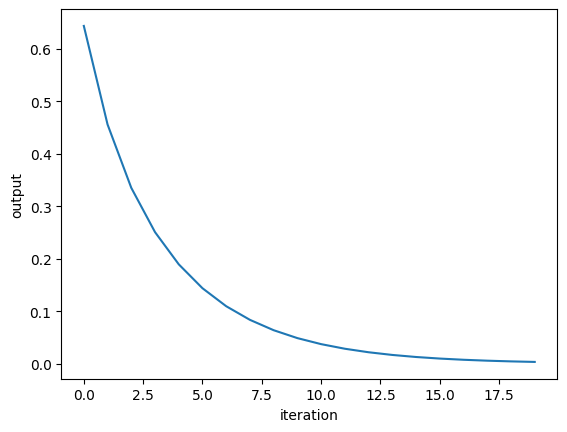

In [24]:
import math

vals = []
val = 1 # initial hidden value
for i in range(20):
    val = np.tanh(.7645*val)
    vals.append(val)
plt.figure()
plt.plot(vals)
plt.xlabel('iteration')
plt.ylabel('output')
plt.show()

Consider our example:

> “I grew up in <u>France</u> ... I speak fluent <u>French</u>.”

Somehow we need to "remember" *France* until we get to *French*.

But, the graph above shows there is exponential decay in the value of a hidden unit over time.

So, if the hidden unit at time $1$ represents *France*, it cannot maintain that value very long.


**vanishing gradients in back-propagation**

An analogous problem exists in the backward direction.

Consider how the gradient with respect to a single output affects earlier hidden units.

E.g., at training time, if we predict "Spanish" instead of "French", we need to somehow updated the hidden unit produced by "France" many steps prior.


![figs/bpt.png](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/bpt.png?raw=1)

Recall [backpropagation equation](https://github.com/tulane-cmps6730/main/blob/main/lec/classify/neural.ipynb) for simple neural network. It uses the chain rule in calculus:

$$
f(x) = g(h(x))\\
f'(x) = g'(h(x)) \cdot h'(x)
$$

$$
y_3 = W_{hy} h_3\\
h_3 = \mathrm{tanh}(W_{hh}h_{2})\\
h_2 = \mathrm{tanh}(W_{hh}h_{1})\\
$$

$$
y_3 = W_{hy} \cdot \mathrm{tanh}(W_{hh} \cdot \mathrm{tanh}(W_{hh} \cdot h_1)))
$$


$$
\frac{\partial y_3}{\partial h_1} = \frac{\partial y_3}{\partial h_3}\frac{\partial h_3}{\partial h_2}\frac{\partial h_2}{\partial h_1}
$$

- Just like in the forward pass, we end up with a chain of multiplications that can exponentially decay to 0

$$
\begin{align}
\frac{\partial y_{t+k}}{\partial h_{t}} & = & \frac{\partial y_{t+k}}{\partial h_{t+k}} \prod_{i=0}^k \frac{\partial{h_i}}{\partial{h_{i-1}}}\\
& = & \frac{\partial y_{t+k}}{\partial h_{t+k}} W_{hh}^k \prod_{i=0}^k \frac{\partial{h_i}}{\partial{h_{i-1}}}
\end{align}
$$

If $W_{hh}$ is small, then raising it to the power of $k$ will make it exponentially smaller.

<br><br><br>
So, how can we pass information in the hidden state forward/backward over long distances?

<br><br><br>

It would be nice if we could somehow just copy a part of the hidden state forward without requiring a multiplication.


<hr size=10 color=#285C4D>

## Long short-term memory (LSTM)

### Overview


The idea of LSTMs is to introduce a <u>memory cell</u>:
  - a state that stores the information from prior steps
  - explicitly allows remembering and forgetting of prior state information
  - by altering the transition function, we can ensure that the gradient does not explode/vanish over time.


<br><br>

Where does the name come from?
- **Long-term memory**: The parameters of the model, which are shared across time steps, are analogous to long-term memory.
- **Short-term memory**: The hidden layers represent short-term memory, since they can change as new input is read.


<br><br>

Consider a traditional recurrent neural network:

![rnn](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/rnn.png?raw=1)

An LSTM makes several changes:
![lstm](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/lstm1.png?raw=1)

![notation](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/notation.png?raw=1)

<br>



### Cell State ($C_t$)


The core idea of LSTM is to introduce a cell state $C_t$ (a memory cell)

![cellstate](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/cellstate.png?raw=1)

We'll see below that the cell state $C_t$ is a simpler linear function of the prior cell state $C_{t-1}$, which is what prevents the vanishing gradient problem.

There are several gates that will decide what information is included in the cell state.



### Input Gate



![input](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/input.png?raw=1)

Note shorthand: $W_i \cdot[h_{t-1}, x_t] = W_{ih} h_{t-1} + W_{ix}x_t$

The input gate decides what new information to add to the memory cell.  

- First, a sigmoid layer called the “input gate layer” decides which values we’ll update.
- Next, a tanh layer creates a vector of new candidate values, $\tilde{C}_t$, that could be added to the state.
- E.g., we can add information about "French" into the memory cell.




### Forget Gate





![forget](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/forget.png?raw=1)

The forgate gate decides what old information to remove from the memory cell.

The forget gate outputs a number between 0 and 1 for each number in the cell state $C_{t−1}$.
  - 1 means keep this number
  - 0 means forget this number
  
E.g., in "French" example, 1 means keep the information about "France" in the cell state, so it can be used later to predict the term "French."



### Updating the Cell State




![update](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/update.png?raw=1)

To create the new state, we:
- Multiply the old state by $f_t$, forgetting the things we decided to forget earlier.
- Then we add $i_t*\tilde{C}_t$; this is the new candidate values, scaled by how much we decided to update each state value.
  - Note that the "*" notation here is the [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices))
  
$$
\begin{bmatrix}
1 & 2\\
3 & 4\\
\end{bmatrix}
*
\begin{bmatrix}
1 & 2\\
3 & 4\\
\end{bmatrix}
=
\begin{bmatrix}
1 & 4\\
9 & 16\\
\end{bmatrix}
$$

### Output Gate


![output](https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/output.png?raw=1)

The output gate determines what portion of the memory cell is put back in the hidden state $h$

- First, apply a sigmoid layer to decide which parts of the memory cell state to output.
- Then, apply a tanh layer (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the chosen parts.

<br>

Note: if we just used $f_t=1$ for all $t$, we would just remember all cell states, without forgetting any information.
- This would already address the diminishing gradient problem.
- The forgetting allows for a sparser, more efficient model.

### LSTM summary



$$
\begin{align}
\hbox{hidden state}~~~ h_t & = & o_t * \mathrm{tanh}(C_t)\\
\hbox{memory cell}~~~ C_t & = & f_t * C_{t-1} + i_t * \tilde{C}_t \\
\hbox{candidate additions}~~~ \tilde{C}_t & = & \mathrm{tanh}(W_{Ch} h_{t-1} + W_{Cx} x_t)\\
\hbox{output gate}~~~ o_t & = & \sigma (W_{oh} h_{t-1} + W_{ox} x_t)\\
\hbox{forget gate}~~~ f_t & = & \sigma(W_{fh} h_{t-1} + W_{fx} x_t)\\
\hbox{input gate}~~~ i_t & = & \sigma(W_{ih} h_{t-1} + W_{ix} x_t)
\end{align}
$$

### LSTM Implementation

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, chars, verbose=True):
        super(LSTM, self).__init__()
        self.verbose = verbose
        self.n_hidden = hidden_size
        # input gate
        self.W_ih = nn.Linear(hidden_size, hidden_size)
        self.W_ix = nn.Linear(input_size, hidden_size)
        # forget gate
        self.W_fh = nn.Linear(hidden_size, hidden_size)
        self.W_fx = nn.Linear(input_size, hidden_size)
        # output gate
        self.W_oh = nn.Linear(hidden_size, hidden_size)
        self.W_ox = nn.Linear(input_size, hidden_size)
        # memory cell
        self.W_ch = nn.Linear(hidden_size, hidden_size)
        self.W_cx = nn.Linear(input_size, hidden_size)
        # prediction
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
        self.chars = chars

    def forward(self, x, h_prev, c_prev):
        in_gate = torch.sigmoid(self.W_ih(h_prev) + self.W_ix(x))
        forget_gate = torch.sigmoid(self.W_fh(h_prev) + self.W_fx(x))
        output_gate = torch.sigmoid(self.W_oh(h_prev) + self.W_ox(x))
        cell_gate = self.tanh(self.W_ch(h_prev) + self.W_cx(x))

        c_new = forget_gate * c_prev + in_gate * cell_gate
        h_new = output_gate * torch.tanh(c_new)
        output = self.hidden_to_output(h_new)
        # output = self.softmax(self.hidden_to_output(h_new))

        if self.verbose:
            df = pd.DataFrame([{
                               'input:':  output2label(x, self.chars),
                               'h_new:': pp(h_new),
                               'c_new:': pp(c_new),
                               'in:': pp(in_gate),
                               'forget:': pp(forget_gate),
                               'output_gate:': pp(output_gate),
                               'cell:': pp(cell_gate),
                               'output:': pp(output),
                               'top output:':  output2label(output, self.chars)}]).transpose()
            display(df)

        return output, h_new, c_new

    def forward_unrolled(self, x_list):
        """
        Given a character list, unroll the network and gather
        predictions for each time step.
        """
        hidden = torch.zeros(1, self.n_hidden)
        cell = torch.zeros(1, self.n_hidden)
        outputs = []
        hiddens = []
        cells = []
        for x in x_list[:-1]: # no prediction for final step
            output, hidden, cell = self.forward(x, hidden, cell)
            outputs.append(output)
            hiddens.append(hidden)
            cells.append(cell)
        return torch.cat(outputs), hiddens, cells

def output2label(output, chars):
    """
    return the letter for the most probable prediction
    """
    top_n, top_i = output.topk(1)
    return chars[top_i.item()] # , math.exp(top_n)

def outputs2label(outputs, chars):
    return [output2label(o, chars) for o in outputs]

In [26]:
torch.random.manual_seed(42)
chars = ['a', 'b', 'c']
char2int = {'a': 0, 'b': 1, 'c': 2}
int2char = {0: 'a', 1: 'b', 2: 'c'}

x = char2vec('c', char2int)
n_hidden = 3
lstm = LSTM(len(chars), n_hidden, len(chars), chars, verbose=True)
output, hidden, cell = lstm.forward(x, torch.zeros(1, n_hidden),
                                    torch.zeros(1, n_hidden))

,0
input:,c
h_new:,"[0.06, 0.03, -0.04]"
c_new:,"[0.14, 0.04, -0.11]"
in:,"[0.45, 0.59, 0.56]"
forget:,"[0.48, 0.5, 0.69]"
output_gate:,"[0.46, 0.7, 0.36]"
cell:,"[0.32, 0.06, -0.19]"
output:,"[-0.36, -0.54, -0.33]"
top output:,c


epoch=0


Epoch 1/2: 100%|██████████| 150/150 [00:01<00:00, 105.91sample/s, Batch=15, Loss=0.18]


Epoch [1/2], Average Loss: 0.6495
epoch=1


Epoch 2/2: 100%|██████████| 150/150 [00:01<00:00, 118.16sample/s, Batch=15, Loss=0.00412]


Epoch [2/2], Average Loss: 0.0347


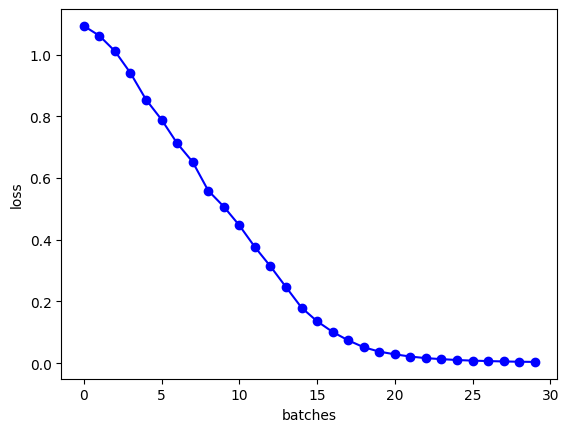

In [27]:

data = [
    chars2vec('abcabcabc', char2int),
    chars2vec('bcabcabca', char2int),
    chars2vec('cabcabcab', char2int)
]  * 50

lstm = train_model(lstm, data, epochs=2, learning_rate=.1, batch_size=10)

In [28]:
lstm.verbose=True
x = chars2vec('abc', char2int)
outputs, _, _ = lstm.forward_unrolled(x)

,0
input:,a
h_new:,"[-0.68, -0.74, 0.73]"
c_new:,"[-0.85, -0.95, 0.95]"
in:,"[0.98, 0.99, 0.98]"
forget:,"[0.02, 0.05, 0.09]"
output_gate:,"[0.99, 1.0, 0.99]"
cell:,"[-0.87, -0.95, 0.96]"
output:,"[-3.32, 4.2, -0.52]"
top output:,b


,0
input:,b
h_new:,"[0.64, -0.96, -0.76]"
c_new:,"[0.98, -1.91, -1.0]"
in:,"[0.99, 0.99, 1.0]"
forget:,"[0.02, 0.98, 0.0]"
output_gate:,"[0.85, 1.0, 1.0]"
cell:,"[1.0, -0.99, -1.0]"
output:,"[-1.79, -1.82, 4.71]"
top output:,c


epoch=0


Epoch 1/2: 100%|██████████| 150/150 [00:00<00:00, 335.95sample/s, Batch=15, Loss=0.0223]


Epoch [1/2], Average Loss: 0.2938
epoch=1


Epoch 2/2: 100%|██████████| 150/150 [00:00<00:00, 332.76sample/s, Batch=15, Loss=0.00403]


Epoch [2/2], Average Loss: 0.0089


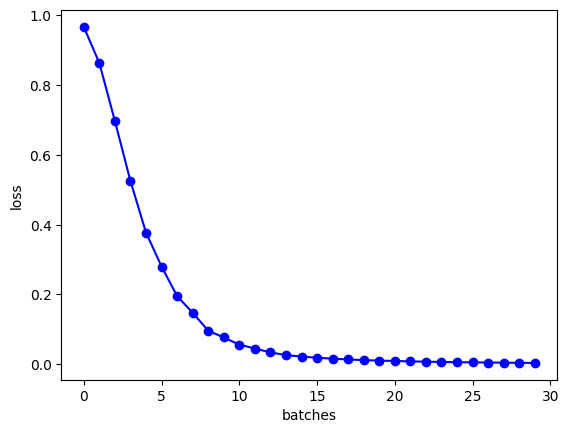

,0
input,a
h_new,"[0.81, 0.93, -0.92]"
output,"[-3.75, 4.86, -1.42]"
top output,b


,0
input,b
h_new,"[1.0, -1.0, 0.96]"
output,"[0.43, -2.46, 5.5]"
top output,c


tensor([[-3.7516,  4.8573, -1.4197],
        [ 0.4325, -2.4635,  5.5018]], grad_fn=<CatBackward0>)


In [29]:
rnn = RNN(len(chars), n_hidden, len(chars), chars, verbose=True)
rnn = train_model(rnn, data, epochs=2, learning_rate=.1, batch_size=10)

rnn.verbose=True
x = chars2vec('abc', char2int)
outputs, _  = rnn.forward_unrolled(x)
print(outputs)

<hr size=10 color=#285C4D>

## Comparing the "memories" of LSTMs and RNNs

How can we compare the "memory" abilities of LSTM vs RNN?

<br><br><br>

Let's devise a synthetic task. We observe two types of sequences:

> 'bc**a**bcbcbc**a**'

> 'bcbcbcbcbc'

The network needs to learn that when it sees an 'a', it must remember this in order to output another 'a' 7 time steps later.

epoch=0


Epoch 1/40: 100%|██████████| 20/20 [00:00<00:00, 109.66sample/s, Batch=2, Loss=1.02]


Epoch [1/40], Average Loss: 1.0653
epoch=1


Epoch 2/40: 100%|██████████| 20/20 [00:00<00:00, 101.15sample/s, Batch=2, Loss=0.867]


Epoch [2/40], Average Loss: 0.8893
epoch=2


Epoch 3/40: 100%|██████████| 20/20 [00:00<00:00, 99.53sample/s, Batch=2, Loss=0.607] 


Epoch [3/40], Average Loss: 0.6996
epoch=3


Epoch 4/40: 100%|██████████| 20/20 [00:00<00:00, 86.40sample/s, Batch=2, Loss=0.427]


Epoch [4/40], Average Loss: 0.5159
epoch=4


Epoch 5/40: 100%|██████████| 20/20 [00:00<00:00, 107.11sample/s, Batch=2, Loss=0.334]


Epoch [5/40], Average Loss: 0.4125
epoch=5


Epoch 6/40: 100%|██████████| 20/20 [00:00<00:00, 104.61sample/s, Batch=2, Loss=0.312]


Epoch [6/40], Average Loss: 0.3299
epoch=6


Epoch 7/40: 100%|██████████| 20/20 [00:00<00:00, 111.40sample/s, Batch=2, Loss=0.278]


Epoch [7/40], Average Loss: 0.2839
epoch=7


Epoch 8/40: 100%|██████████| 20/20 [00:00<00:00, 95.28sample/s, Batch=2, Loss=0.321]


Epoch [8/40], Average Loss: 0.2670
epoch=8


Epoch 9/40: 100%|██████████| 20/20 [00:00<00:00, 93.98sample/s, Batch=2, Loss=0.239]


Epoch [9/40], Average Loss: 0.2636
epoch=9


Epoch 10/40: 100%|██████████| 20/20 [00:00<00:00, 106.80sample/s, Batch=2, Loss=0.253]


Epoch [10/40], Average Loss: 0.2550
epoch=10


Epoch 11/40: 100%|██████████| 20/20 [00:00<00:00, 101.05sample/s, Batch=2, Loss=0.327]


Epoch [11/40], Average Loss: 0.2595
epoch=11


Epoch 12/40: 100%|██████████| 20/20 [00:00<00:00, 106.70sample/s, Batch=2, Loss=0.246]


Epoch [12/40], Average Loss: 0.2493
epoch=12


Epoch 13/40: 100%|██████████| 20/20 [00:00<00:00, 82.59sample/s, Batch=2, Loss=0.261]


Epoch [13/40], Average Loss: 0.2392
epoch=13


Epoch 14/40: 100%|██████████| 20/20 [00:00<00:00, 106.16sample/s, Batch=2, Loss=0.227]


Epoch [14/40], Average Loss: 0.2418
epoch=14


Epoch 15/40: 100%|██████████| 20/20 [00:00<00:00, 99.46sample/s, Batch=2, Loss=0.251] 


Epoch [15/40], Average Loss: 0.2356
epoch=15


Epoch 16/40: 100%|██████████| 20/20 [00:00<00:00, 106.26sample/s, Batch=2, Loss=0.19]


Epoch [16/40], Average Loss: 0.2325
epoch=16


Epoch 17/40: 100%|██████████| 20/20 [00:00<00:00, 98.78sample/s, Batch=2, Loss=0.225] 


Epoch [17/40], Average Loss: 0.2262
epoch=17


Epoch 18/40: 100%|██████████| 20/20 [00:00<00:00, 88.76sample/s, Batch=2, Loss=0.241]


Epoch [18/40], Average Loss: 0.2232
epoch=18


Epoch 19/40: 100%|██████████| 20/20 [00:00<00:00, 106.65sample/s, Batch=2, Loss=0.219]


Epoch [19/40], Average Loss: 0.2200
epoch=19


Epoch 20/40: 100%|██████████| 20/20 [00:00<00:00, 101.01sample/s, Batch=2, Loss=0.206]


Epoch [20/40], Average Loss: 0.2186
epoch=20


Epoch 21/40: 100%|██████████| 20/20 [00:00<00:00, 106.13sample/s, Batch=2, Loss=0.194]


Epoch [21/40], Average Loss: 0.2088
epoch=21


Epoch 22/40: 100%|██████████| 20/20 [00:00<00:00, 78.65sample/s, Batch=2, Loss=0.21]


Epoch [22/40], Average Loss: 0.1990
epoch=22


Epoch 23/40: 100%|██████████| 20/20 [00:00<00:00, 106.05sample/s, Batch=2, Loss=0.167]


Epoch [23/40], Average Loss: 0.1835
epoch=23


Epoch 24/40: 100%|██████████| 20/20 [00:00<00:00, 102.35sample/s, Batch=2, Loss=0.152]


Epoch [24/40], Average Loss: 0.1885
epoch=24


Epoch 25/40: 100%|██████████| 20/20 [00:00<00:00, 106.05sample/s, Batch=2, Loss=0.157]


Epoch [25/40], Average Loss: 0.1603
epoch=25


Epoch 26/40: 100%|██████████| 20/20 [00:00<00:00, 109.47sample/s, Batch=2, Loss=0.161]


Epoch [26/40], Average Loss: 0.1564
epoch=26


Epoch 27/40: 100%|██████████| 20/20 [00:00<00:00, 84.42sample/s, Batch=2, Loss=0.143]


Epoch [27/40], Average Loss: 0.1340
epoch=27


Epoch 28/40: 100%|██████████| 20/20 [00:00<00:00, 98.97sample/s, Batch=2, Loss=0.117] 


Epoch [28/40], Average Loss: 0.1302
epoch=28


Epoch 29/40: 100%|██████████| 20/20 [00:00<00:00, 70.78sample/s, Batch=2, Loss=0.127]


Epoch [29/40], Average Loss: 0.1291
epoch=29


Epoch 30/40: 100%|██████████| 20/20 [00:00<00:00, 55.39sample/s, Batch=2, Loss=0.125]


Epoch [30/40], Average Loss: 0.1172
epoch=30


Epoch 31/40: 100%|██████████| 20/20 [00:00<00:00, 70.44sample/s, Batch=2, Loss=0.0974]


Epoch [31/40], Average Loss: 0.1063
epoch=31


Epoch 32/40: 100%|██████████| 20/20 [00:00<00:00, 69.89sample/s, Batch=2, Loss=0.0933]


Epoch [32/40], Average Loss: 0.1130
epoch=32


Epoch 33/40: 100%|██████████| 20/20 [00:00<00:00, 66.67sample/s, Batch=2, Loss=0.113]


Epoch [33/40], Average Loss: 0.1087
epoch=33


Epoch 34/40: 100%|██████████| 20/20 [00:00<00:00, 65.74sample/s, Batch=2, Loss=0.0935]


Epoch [34/40], Average Loss: 0.0912
epoch=34


Epoch 35/40: 100%|██████████| 20/20 [00:00<00:00, 66.50sample/s, Batch=2, Loss=0.0949]


Epoch [35/40], Average Loss: 0.0975
epoch=35


Epoch 36/40: 100%|██████████| 20/20 [00:00<00:00, 57.32sample/s, Batch=2, Loss=0.085]


Epoch [36/40], Average Loss: 0.0855
epoch=36


Epoch 37/40: 100%|██████████| 20/20 [00:00<00:00, 32.53sample/s, Batch=2, Loss=0.0906]


Epoch [37/40], Average Loss: 0.0887
epoch=37


Epoch 38/40: 100%|██████████| 20/20 [00:00<00:00, 31.63sample/s, Batch=2, Loss=0.0829]


Epoch [38/40], Average Loss: 0.0841
epoch=38


Epoch 39/40: 100%|██████████| 20/20 [00:00<00:00, 21.27sample/s, Batch=2, Loss=0.0824]


Epoch [39/40], Average Loss: 0.0824
epoch=39


Epoch 40/40: 100%|██████████| 20/20 [00:00<00:00, 46.09sample/s, Batch=2, Loss=0.0813]


Epoch [40/40], Average Loss: 0.0818


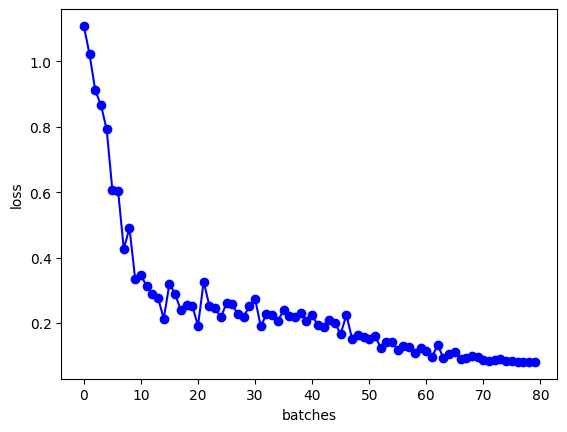

In [30]:
pd.set_option('display.max_colwidth', 200)
data = [
    chars2vec('bcabcbcbca', char2int),
    chars2vec('bcbcbcbcbc', char2int),
]  * 10

lstm = LSTM(len(chars), 7, len(chars), chars, verbose=True)
lstm = train_model(lstm, data, epochs=40, learning_rate=.1, batch_size=10)

In [31]:
lstm.verbose=False
x = chars2vec('bcabcbcbca', char2int)
outputs, hiddens, cells = lstm.forward_unrolled(x)
# what is last letter predicted?
print('last letter predicted=', output2label(outputs[-1], chars))

# print contents of memory cell state after each input letter.
# by examing memory cell, we can inspect which dimensions
# are responsible for "remembering" that we saw "a"
print('memory cells:')
pd.DataFrame([pp(c) for c in cells],
             index=pd.Index(list('bcabcbcbca')[:-1], name='input'))

last letter predicted= a
memory cells:


,0,1,2,3,4,5,6
input,,,,,,,
b,-0.95,-0.94,0.83,-0.77,-0.81,0.98,-0.92
c,-1.94,-1.72,0.80,-0.74,0.99,-0.03,-1.91
a,-2.93,-2.71,1.79,0.92,1.36,-0.99,-2.91
b,-3.92,-3.40,2.79,-1.00,-0.86,-1.41,-3.90
c,-4.91,-2.16,3.23,0.98,1.00,-2.39,-4.90
b,-5.80,-2.65,4.21,-1.00,-0.99,-1.25,-5.89
c,-6.79,-0.95,4.35,0.90,1.00,-2.23,-6.89
b,-7.57,-1.70,5.30,-1.00,-0.99,0.35,-7.79
c,-8.56,-1.82,5.28,-0.77,1.00,-0.65,-8.79


In [32]:
# compare with bcbcbcbcbc (so, no "a" to remember)
x = chars2vec('bcbcbcbcbc', char2int)
outputs, hiddens, cells = lstm.forward_unrolled(x)
# what is last letter predicted?
print('last letter predicted=', output2label(outputs[-1], chars))
print('memory cells:')
pd.DataFrame([pp(c) for c in cells],
             index=pd.Index(list('bcbcbcbcbc')[:-1], name='input'))

last letter predicted= c
memory cells:


,0,1,2,3,4,5,6
input,,,,,,,
b,-0.95,-0.94,0.83,-0.77,-0.81,0.98,-0.92
c,-1.94,-1.72,0.80,-0.74,0.99,-0.03,-1.91
b,-2.92,-2.62,1.79,-1.00,0.68,0.40,-2.89
c,-3.92,-3.51,2.32,0.69,1.00,-0.62,-3.89
b,-4.90,-4.19,3.32,-1.00,-0.82,-1.17,-4.89
c,-5.90,-2.70,3.72,0.98,1.00,-2.16,-5.89
b,-6.78,-3.10,4.70,-1.00,-0.99,-1.17,-6.87
c,-7.77,-1.13,4.84,0.89,1.00,-2.16,-7.87
b,-8.54,-1.86,5.78,-1.00,-0.99,0.35,-8.76


Examining the last row above, what looks different? What tells the network to produce "a" at the next time step?

It appears that this LSTM has learned to "remember" the character "a" for later use.

<br><br>

How does the RNN do?

epoch=0


Epoch 1/40: 100%|██████████| 20/20 [00:00<00:00, 116.80sample/s, Batch=2, Loss=0.887]


Epoch [1/40], Average Loss: 1.0896
epoch=1


Epoch 2/40: 100%|██████████| 20/20 [00:00<00:00, 190.87sample/s, Batch=2, Loss=0.357]


Epoch [2/40], Average Loss: 0.5567
epoch=2


Epoch 3/40: 100%|██████████| 20/20 [00:00<00:00, 75.80sample/s, Batch=2, Loss=0.357]


Epoch [3/40], Average Loss: 0.4802
epoch=3


Epoch 4/40: 100%|██████████| 20/20 [00:00<00:00, 199.30sample/s, Batch=2, Loss=0.293]


Epoch [4/40], Average Loss: 0.3312
epoch=4


Epoch 5/40: 100%|██████████| 20/20 [00:00<00:00, 185.48sample/s, Batch=2, Loss=0.325]


Epoch [5/40], Average Loss: 0.3008
epoch=5


Epoch 6/40: 100%|██████████| 20/20 [00:00<00:00, 80.89sample/s, Batch=2, Loss=0.324]


Epoch [6/40], Average Loss: 0.2731
epoch=6


Epoch 7/40: 100%|██████████| 20/20 [00:00<00:00, 97.93sample/s, Batch=2, Loss=0.256]


Epoch [7/40], Average Loss: 0.2575
epoch=7


Epoch 8/40: 100%|██████████| 20/20 [00:00<00:00, 113.64sample/s, Batch=2, Loss=0.211]


Epoch [8/40], Average Loss: 0.2592
epoch=8


Epoch 9/40: 100%|██████████| 20/20 [00:00<00:00, 143.16sample/s, Batch=2, Loss=0.218]


Epoch [9/40], Average Loss: 0.2558
epoch=9


Epoch 10/40: 100%|██████████| 20/20 [00:00<00:00, 79.21sample/s, Batch=2, Loss=0.222]


Epoch [10/40], Average Loss: 0.2465
epoch=10


Epoch 11/40: 100%|██████████| 20/20 [00:00<00:00, 75.78sample/s, Batch=2, Loss=0.248]


Epoch [11/40], Average Loss: 0.2478
epoch=11


Epoch 12/40: 100%|██████████| 20/20 [00:00<00:00, 63.84sample/s, Batch=2, Loss=0.214]


Epoch [12/40], Average Loss: 0.2463
epoch=12


Epoch 13/40: 100%|██████████| 20/20 [00:00<00:00, 136.70sample/s, Batch=2, Loss=0.215]


Epoch [13/40], Average Loss: 0.2383
epoch=13


Epoch 14/40: 100%|██████████| 20/20 [00:00<00:00, 177.03sample/s, Batch=2, Loss=0.246]


Epoch [14/40], Average Loss: 0.2304
epoch=14


Epoch 15/40: 100%|██████████| 20/20 [00:00<00:00, 120.42sample/s, Batch=2, Loss=0.242]


Epoch [15/40], Average Loss: 0.2235
epoch=15


Epoch 16/40: 100%|██████████| 20/20 [00:00<00:00, 312.75sample/s, Batch=2, Loss=0.201]


Epoch [16/40], Average Loss: 0.2061
epoch=16


Epoch 17/40: 100%|██████████| 20/20 [00:00<00:00, 324.08sample/s, Batch=2, Loss=0.207]


Epoch [17/40], Average Loss: 0.1945
epoch=17


Epoch 18/40: 100%|██████████| 20/20 [00:00<00:00, 300.81sample/s, Batch=2, Loss=0.189]


Epoch [18/40], Average Loss: 0.1893
epoch=18


Epoch 19/40: 100%|██████████| 20/20 [00:00<00:00, 243.85sample/s, Batch=2, Loss=0.179]


Epoch [19/40], Average Loss: 0.1890
epoch=19


Epoch 20/40: 100%|██████████| 20/20 [00:00<00:00, 239.38sample/s, Batch=2, Loss=0.217]


Epoch [20/40], Average Loss: 0.1920
epoch=20


Epoch 21/40: 100%|██████████| 20/20 [00:00<00:00, 249.53sample/s, Batch=2, Loss=0.186]


Epoch [21/40], Average Loss: 0.1867
epoch=21


Epoch 22/40: 100%|██████████| 20/20 [00:00<00:00, 270.93sample/s, Batch=2, Loss=0.218]


Epoch [22/40], Average Loss: 0.1879
epoch=22


Epoch 23/40: 100%|██████████| 20/20 [00:00<00:00, 263.62sample/s, Batch=2, Loss=0.18]


Epoch [23/40], Average Loss: 0.1885
epoch=23


Epoch 24/40: 100%|██████████| 20/20 [00:00<00:00, 300.46sample/s, Batch=2, Loss=0.191]


Epoch [24/40], Average Loss: 0.1862
epoch=24


Epoch 25/40: 100%|██████████| 20/20 [00:00<00:00, 304.59sample/s, Batch=2, Loss=0.177]


Epoch [25/40], Average Loss: 0.1780
epoch=25


Epoch 26/40: 100%|██████████| 20/20 [00:00<00:00, 257.02sample/s, Batch=2, Loss=0.184]


Epoch [26/40], Average Loss: 0.1759
epoch=26


Epoch 27/40: 100%|██████████| 20/20 [00:00<00:00, 301.40sample/s, Batch=2, Loss=0.166]


Epoch [27/40], Average Loss: 0.1670
epoch=27


Epoch 28/40: 100%|██████████| 20/20 [00:00<00:00, 326.92sample/s, Batch=2, Loss=0.167]


Epoch [28/40], Average Loss: 0.1673
epoch=28


Epoch 29/40: 100%|██████████| 20/20 [00:00<00:00, 298.69sample/s, Batch=2, Loss=0.162]


Epoch [29/40], Average Loss: 0.1633
epoch=29


Epoch 30/40: 100%|██████████| 20/20 [00:00<00:00, 278.09sample/s, Batch=2, Loss=0.172]


Epoch [30/40], Average Loss: 0.1687
epoch=30


Epoch 31/40: 100%|██████████| 20/20 [00:00<00:00, 213.42sample/s, Batch=2, Loss=0.171]


Epoch [31/40], Average Loss: 0.1648
epoch=31


Epoch 32/40: 100%|██████████| 20/20 [00:00<00:00, 207.90sample/s, Batch=2, Loss=0.161]


Epoch [32/40], Average Loss: 0.1619
epoch=32


Epoch 33/40: 100%|██████████| 20/20 [00:00<00:00, 232.63sample/s, Batch=2, Loss=0.161]


Epoch [33/40], Average Loss: 0.1580
epoch=33


Epoch 34/40: 100%|██████████| 20/20 [00:00<00:00, 287.39sample/s, Batch=2, Loss=0.166]


Epoch [34/40], Average Loss: 0.1619
epoch=34


Epoch 35/40: 100%|██████████| 20/20 [00:00<00:00, 314.59sample/s, Batch=2, Loss=0.156]


Epoch [35/40], Average Loss: 0.1613
epoch=35


Epoch 36/40: 100%|██████████| 20/20 [00:00<00:00, 295.71sample/s, Batch=2, Loss=0.157]


Epoch [36/40], Average Loss: 0.1574
epoch=36


Epoch 37/40: 100%|██████████| 20/20 [00:00<00:00, 301.19sample/s, Batch=2, Loss=0.155]


Epoch [37/40], Average Loss: 0.1582
epoch=37


Epoch 38/40: 100%|██████████| 20/20 [00:00<00:00, 253.11sample/s, Batch=2, Loss=0.156]


Epoch [38/40], Average Loss: 0.1582
epoch=38


Epoch 39/40: 100%|██████████| 20/20 [00:00<00:00, 285.65sample/s, Batch=2, Loss=0.158]


Epoch [39/40], Average Loss: 0.1578
epoch=39


Epoch 40/40: 100%|██████████| 20/20 [00:00<00:00, 312.56sample/s, Batch=2, Loss=0.156]


Epoch [40/40], Average Loss: 0.1566


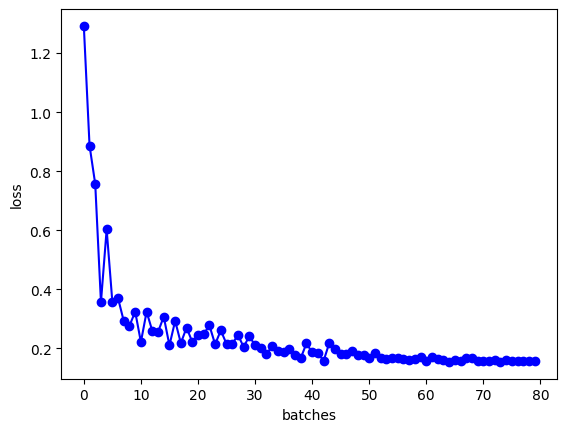

In [33]:
rnn = RNN(len(chars), 7, len(chars), chars, verbose=True)
rnn = train_model(rnn, data, epochs=40, learning_rate=.1, batch_size=10)

In [34]:
rnn.verbose=False
x = chars2vec('bcabcbcbca', char2int)
outputs, hiddens = rnn.forward_unrolled(x)
# what is last letter predicted?
print('last letter predicted=', output2label(outputs[-1], chars))

# print contents of hidden state state after each input letter.
# by examing hidden state, we can inspect which dimensions
# are responsible for "remembering" that we saw "a"
print('hidden state:')
pd.DataFrame([pp(h) for h in hiddens],
             index=pd.Index(list('bcabcbcbca')[:-1], name='input'))

last letter predicted= b
hidden state:


,0,1,2,3,4,5,6
input,,,,,,,
b,-0.66,-0.40,-0.19,0.89,-0.98,-0.98,0.83
c,-0.89,1.00,0.99,-0.99,-1.00,0.99,-0.98
a,0.51,1.00,1.00,-0.97,0.94,-0.56,-0.21
b,-1.00,-0.99,0.96,1.00,0.96,-1.00,1.00
c,-1.00,0.95,1.00,-0.97,-0.99,-0.98,-0.93
b,0.78,0.96,1.00,0.95,-0.98,-1.00,0.97
c,-1.00,1.00,1.00,-0.98,0.99,-0.59,0.17
b,-1.00,-0.95,1.00,0.99,-0.89,-1.00,0.99
c,-0.97,1.00,1.00,-1.00,-0.99,0.96,-0.99


The RNN predicts 'b' in the last time step instead of 'a'.

Now, the comparison isn't totally fair -- the LSTM has a lot more parameters (how many more?)

We can increase the hidden size for the RNN. It will likely eventually have enough parameters to "remember" the letter 'a'.

But, the LSTM makes more efficient use of the parameters it has in order to propagate information longer distances in the sequence.


In [35]:
# compare with bcbcbcbcbc (so, no "a" to remember)
x = chars2vec('bcbcbcbcbc', char2int)
outputs, hiddens = rnn.forward_unrolled(x)
# what is last letter predicted?
print('last letter predicted=', output2label(outputs[-1], chars))
print('hidden state:')
pd.DataFrame([pp(h) for h in hiddens],
             index=pd.Index(list('bcbcbcbcbc')[:-1], name='input'))

last letter predicted= c
hidden state:


,0,1,2,3,4,5,6
input,,,,,,,
b,-0.66,-0.40,-0.19,0.89,-0.98,-0.98,0.83
c,-0.89,1.00,0.99,-0.99,-1.00,0.99,-0.98
b,0.98,1.00,1.00,0.90,-0.95,-0.96,0.96
c,-1.00,1.00,1.00,-0.97,1.00,-0.73,0.42
b,-1.00,-0.96,1.00,0.99,-0.87,-1.00,0.99
c,-0.97,1.00,1.00,-1.00,-0.99,0.96,-0.99
b,0.98,1.00,1.00,0.89,-0.97,-0.96,0.95
c,-1.00,1.00,1.00,-0.97,1.00,-0.71,0.42
b,-1.00,-0.96,1.00,0.99,-0.87,-1.00,0.99


<hr size=10 color=#285C4D>

## Summary



LSTMs support long-range dependencies better than RNNs by
- copying portions of the hidden state into a memory cell
- using addition, rather than multiplication, to propagate memory cell forward

Does not completely solve the problem.

Many variants of this idea:

- GRU - like LSTM, but more concise
  - $h_{t+1}$ is a linear combination of $h_t$ with no changes plus a modified version of $h_t$
  
- Residual Networks (ResNets)
  - add "skip" connections between time steps
  - e.g., directly connect $h_t$ to $h_{t+k}$

<hr size=10 color=#285C4D>

## Group Task

- Consider the LSTM example above for the sequence `bcabcbcbca`. Examine the memory cells printed while processing this sequence:

| input   |     0 |     1 |    2 |     3 |     4 |     5 |     6 |
|:--------|------:|------:|-----:|------:|------:|------:|------:|
| b       | -0.95 | -0.94 | 0.83 | -0.77 | -0.81 |  0.98 | -0.92 |
| c       | -1.94 | -1.72 | 0.8  | -0.74 |  0.99 | -0.03 | -1.91 |
| a       | -2.93 | -2.71 | 1.79 |  0.92 |  1.36 | -0.99 | -2.91 |
| b       | -3.92 | -3.4  | 2.79 | -1    | -0.86 | -1.41 | -3.9  |
| c       | -4.91 | -2.16 | 3.23 |  0.98 |  1    | -2.39 | -4.9  |
| b       | -5.8  | -2.65 | 4.21 | -1    | -0.99 | -1.25 | -5.89 |
| c       | -6.79 | -0.95 | 4.35 |  0.9  |  1    | -2.23 | -6.89 |
| b       | -7.57 | -1.7  | 5.3  | -1    | -0.99 |  0.35 | -7.79 |
| c       | -8.56 | -1.82 | 5.28 | -0.77 |  1    | -0.65 | -8.79 |

- Explain which combinations of hidden dimensions contribute the most to the model outputting the letter `a` at the next time step.

- Consider the RNN trained for the same task:

```python
rnn = RNN(len(chars), 7, len(chars), chars, verbose=True)
rnn = train_model(rnn, data, epochs=40, learning_rate=.1, batch_size=10)
```

- Experiment with different sizes of hidden units, training epochs, and learning rates. What settings result in a RNN that correctly outputs the final `a` in the test sequence `bcabcbcbca`? What settings does the model seem most sensitive to? What does this suggest about training such models in practice?



## sources
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/